In [1]:
# Library Imports
import pandas as pd
from scipy.stats import ttest_ind
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

### EDA
---

In [2]:
data = pd.read_csv('data/WA_Marketing-Campaign.csv')
data.head(3)

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03


In [3]:
data.describe()

,MarketID,LocationID,AgeOfStore,Promotion,week,SalesInThousands
count,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000
mean,5.715328,479.656934,8.503650,2.029197,2.500000,53.466204
std,2.877001,287.973679,6.638345,0.810729,1.119055,16.755216
min,1.000000,1.000000,1.000000,1.000000,1.000000,17.340000
25%,3.000000,216.000000,4.000000,1.000000,1.750000,42.545000
50%,6.000000,504.000000,7.000000,2.000000,2.500000,50.200000
75%,8.000000,708.000000,12.000000,3.000000,3.250000,60.477500
max,10.000000,920.000000,28.000000,3.000000,4.000000,99.650000


In [4]:
data.nunique()

MarketID             10
MarketSize            3
LocationID          137
AgeOfStore           25
Promotion             3
week                  4
SalesInThousands    517
dtype: int64

In [5]:
data.corr()['SalesInThousands']

C:\Users\Ty Martz\AppData\Local\Temp\ipykernel_5420\4048104258.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()['SalesInThousands']


MarketID           -0.192389
LocationID         -0.187852
AgeOfStore         -0.028533
Promotion          -0.059212
week               -0.010984
SalesInThousands    1.000000
Name: SalesInThousands, dtype: float64

<Axes: >

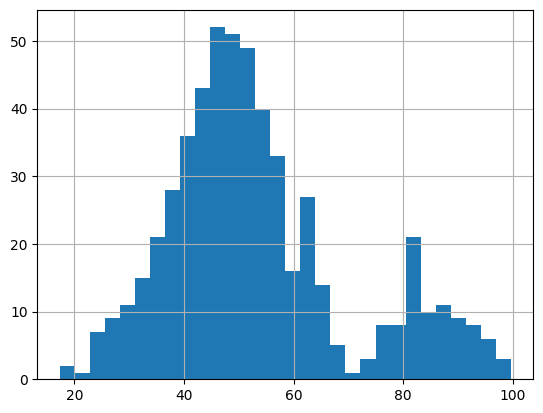

In [6]:
data['SalesInThousands'].hist(bins=30)

### Regression Testing:
---

In [7]:
# Update categorical variables to be encoded
data['Promotion'] = data['Promotion'].astype('category')
dummy_promo = pd.get_dummies(data['Promotion'], prefix='Promo')
dummy_mkt = pd.get_dummies(data['MarketSize'], prefix='Mkt')
data = pd.concat([data, dummy_promo, dummy_mkt], axis=1)

In [8]:
X = data[['MarketID', 'LocationID', 'week', 'Promo_1', 'Promo_2', 'Promo_3', 'Mkt_Small', 'Mkt_Medium', 'Mkt_Large', 'AgeOfStore']]
Y = data['SalesInThousands']

# Linear Regression
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       SalesInThousands   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                     115.8
Date:                Sat, 15 Apr 2023   Prob (F-statistic):          6.89e-112
Time:                        09:27:50   Log-Likelihood:                -2047.6
No. Observations:                 548   AIC:                             4113.
Df Residuals:                     539   BIC:                             4152.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.1356      5.392      7.443      0.0

#### Results:

The promotions and the market sizes were statistically significant in the linear regression analysis with small p-values. AgeOfStore, LocationID, MarketID, and week were not significant. Promotions 1 and 3 had similar coefficients and effects on sales holding all other variables constant. The Large Market size had the largest of all coefficients increasing the sales by ~$28 Thousand. The R-Squared value of 0.63 translates to the proportion of variance in Sales explained by the predictors, giving a decent overall fit.

## A/B Testing
---

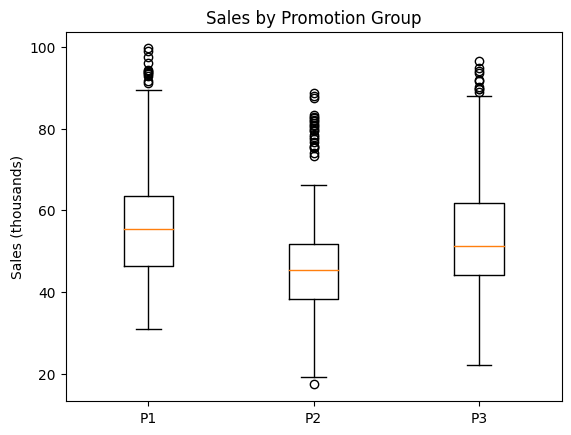

In [9]:
# Load the dataset
df = data.copy()

# Split each promotion group
control = df[df["Promotion"] == 1]["SalesInThousands"]
variant1 = df[df["Promotion"] == 2]["SalesInThousands"]
variant2 = df[df["Promotion"] == 3]["SalesInThousands"]

# View Distributions
plt.boxplot([control, variant1, variant2])
plt.xticks([1, 2, 3], ['P1', 'P2', 'P3'])
plt.ylabel('Sales (thousands)')
plt.title('Sales by Promotion Group')
plt.show()

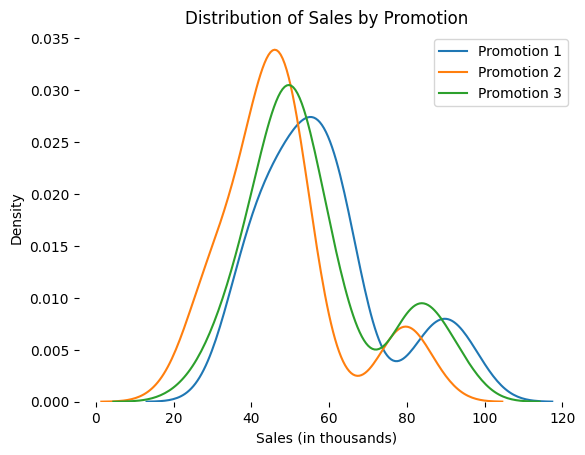

In [10]:
fig, ax = plt.subplots()

# Plot KDE for each promotion
for i in range(1, 4):
    sns.kdeplot(data=data[data["Promotion"]==i]["SalesInThousands"], 
                label="Promotion {}".format(i), 
                ax=ax)
    
ax.set_xlabel("Sales (in thousands)")
ax.set_title("Distribution of Sales by Promotion")

# Remove bars and only show lines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#plt.yticks([])
plt.gca().spines["left"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)

plt.legend()
plt.show()

Interestingly, all promotions have bimodal distributions for sales. This makes me think that there are customers who buy more than the typical distribution across all three test groups so they have similar distributions overall. This is good since both customer groups are captured in each promotion.

In [11]:
# T-tests
t_statistic1, p_value1 = ttest_ind(control, variant1)
t_statistic2, p_value2 = ttest_ind(control, variant2)
t_statistic3, p_value3 = ttest_ind(variant1, variant2)

# Print the results
print("Results of A/B test between control and variant 1:")
print("t-statistic:", t_statistic1)
print("p-value:", p_value1)
print("\nResults of A/B test between control and variant 2:")
print("t-statistic:", t_statistic2)
print("p-value:", p_value2)
print("\nResults of A/B test between variant 1 and variant 2:")
print("t-statistic:", t_statistic3)
print("p-value:", p_value3)

Results of A/B test between control and variant 1:
t-statistic: 6.453671702181005
p-value: 3.5506696512134566e-10

Results of A/B test between control and variant 2:
t-statistic: 1.5551383687293547
p-value: 0.12079667272313277

Results of A/B test between variant 1 and variant 2:
t-statistic: -4.88139271089348
p-value: 1.5628943036277377e-06


#### Results:

As seen similarly in the distributions, Promos 1 and 3 (control and variant 2) are not statistically different. Promotion 2 (variant 1) falls below the rest and has a statistically significant difference with the others not due to randomness.